In [ ]:
# A PyTorch CNN using cloud image stills derived from the 2/3/4 notebooks.

In [37]:
!pip install torch torchvision --quiet

In [38]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import shutil

In [ ]:
# Split data into training/test
from sklearn.model_selection import train_test_split

# data directory
source_dir = "./Training_Test_Data/Trial_1/"
output_base = "./Training_Test_Data/Trial_1/Split_Data"
train_ratio = 0.8

# define image classes
classes = ['Clear', 'Cloudy', 'Overcast']

for cls in classes:
    cls_path = os.path.join(source_dir, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg'))]
    
    train_imgs, test_imgs = train_test_split(images, train_size = train_ratio, random_state=42)

    for split, split_imgs in [('train', train_imgs), ('test', test_imgs)]:
        split_dir = os.path.join(output_base, split, cls)
        print(split_dir)
        os.makedirs(split_dir, exist_ok = True)

        for img in split_imgs:
            src = os.path.join(cls_path, img)
            dst = os.path.join(split_dir, img)
            shutil.copyfile(src, dst)

..//GI_Iceflow_Model/Training_Test_Data/Trial_1/Split_Data/train/Clear
..//GI_Iceflow_Model/Training_Test_Data/Trial_1/Split_Data/test/Clear
..//GI_Iceflow_Model/Training_Test_Data/Trial_1/Split_Data/train/Cloudy
..//GI_Iceflow_Model/Training_Test_Data/Trial_1/Split_Data/test/Cloudy
..//GI_Iceflow_Model/Training_Test_Data/Trial_1/Split_Data/train/Overcast
..//GI_Iceflow_Model/Training_Test_Data/Trial_1/Split_Data/test/Overcast


In [ ]:
# load/normalize images

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

#directories
root_train = "./Training_Test_Data/Trial_1/Split_Data/train"
root_test = "./Training_Test_Data/Trial_1/Split_Data/test"

# set the transform parameters
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# set the batch size
batch_size = 3

# define the training set
trainset = ImageFolder(root=root_train, transform = transform)
trainloader = DataLoader(trainset, batch_size = batch_size,
                         shuffle = True, num_workers = 2)

# define the test set
testset = ImageFolder(root=root_test, transform = transform)
testloader = DataLoader(testset, batch_size = batch_size,
                        shuffle = False, num_workers = 2)

# redefine classes based on the directory structure
classes = trainset.classes

print(classes)

['Clear', 'Cloudy', 'Overcast']


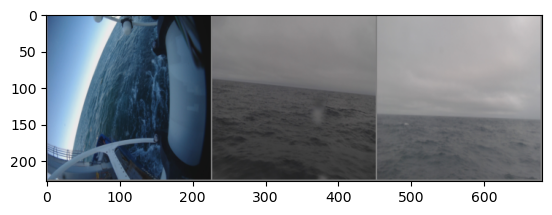

Clear Overcast Overcast


In [41]:
# preview some images

def imshow(img):
    img = img / 2 + 0.5 # reverses the normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [42]:
# define the CNN 

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutional layer 1 -- inputs 3 rgb chanels, outputs 6 feature maps
        self.conv1 = nn.Conv2d(3, 6, 5)
        # pooling operation 1 -- reduces dimension
        self.pool = nn.MaxPool2d(2, 2)
        # convolutional layer 2 -- inputs 6 feature mapts, outputs 16 more complex features
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # implementing adaptive pool to feed info fc's 
        self.adaptive_pool = nn.AdaptiveAvgPool2d((5, 5))
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)  # flatten except batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [43]:
import torch.optim as optim

# spin up a class
net = Net()

# define loss function / optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

Epoch 10: 100%|██████████| 118/118 [00:03<00:00, 33.34it/s, loss=0.898]


Finished Training


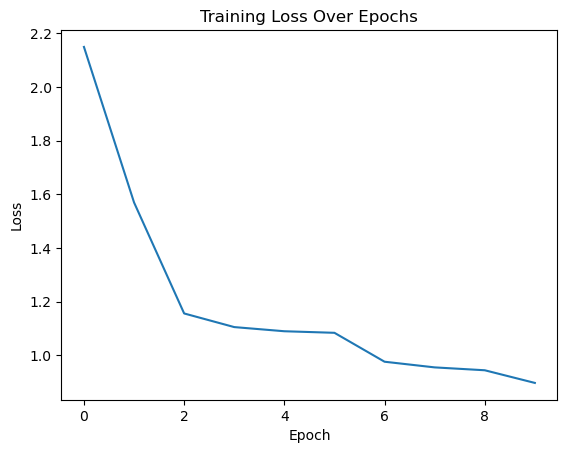

In [44]:
# train cnn
from tqdm import tqdm

loss_graph = []

for epoch in range(10):
    running_loss = 0.0
    loop = tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch+1}")
    
    for i, data in loop:
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Update tqdm progress bar description
        loop.set_postfix(loss=running_loss / (i + 1))

    loss_graph.append(running_loss / (i + 1))

print('Finished Training')

plt.plot(loss_graph)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [45]:
# save model
PATH = './cloud_model.pth'
torch.save(net.state_dict(), PATH)

In [46]:
# look at distribution from test data for confirmation
from collections import Counter

all_labels = []
for _, labels in testloader:
    all_labels.extend(labels.tolist())

print(Counter(all_labels))
# should be 34, 28, 27 for test data set

Counter({1: 34, 0: 28, 2: 27})


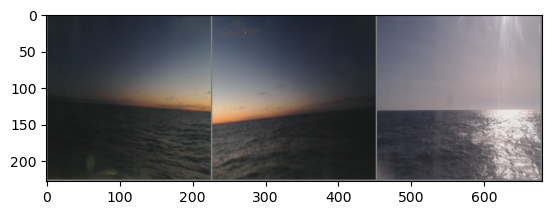

GroundTrush:  Clear Clear Clear


In [47]:
# preview and see if they're pulling correct labels

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTrush: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(3)))

In [48]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only = True))

<All keys matched successfully>

In [49]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range (3)))

Predicted:  Clear Clear Cloudy


In [50]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the CNN on the 89 images: {100 * correct // total} %')

# averages ~62%.. which is better then randomly picking 1/3. 

Accuracy of the CNN on the 89 images: 55 %


In [51]:
# look at class accuracy -- cant help with deciding if we need better annotation/more data

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    

Accuracy for class: Clear is 64.3 %
Accuracy for class: Cloudy is 23.5 %
Accuracy for class: Overcast is 85.2 %


# Trying a third cnn layer

In [601]:
# define the CNN 

class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutional layer 1 -- inputs 3 rgb chanels, outputs 6 feature maps
        self.conv1 = nn.Conv2d(3, 6, 5)
        # pooling operation 1 -- reduces dimension
        self.pool = nn.MaxPool2d(2, 2)
        # convolutional layer 2 -- inputs 6 feature maps, outputs 16 more complex features
        self.conv2 = nn.Conv2d(6, 16, 5)
        # convolutional layer 3 -- inputs 16 feature maps, outputs 32 complex features
        self.conv3 = nn.Conv2d(16, 32, 5)
        # implementing adaptive pool to feed info fc's 
        self.adaptive_pool = nn.AdaptiveAvgPool2d((5, 5))
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)  # flatten except batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [602]:
import torch.optim as optim

# spin up a class
net2 = Net2()

# define loss function / optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr = 0.001, momentum = 0.9)#

Epoch 100: 100%|██████████| 118/118 [00:03<00:00, 36.52it/s, loss=0.186]


Finished Training


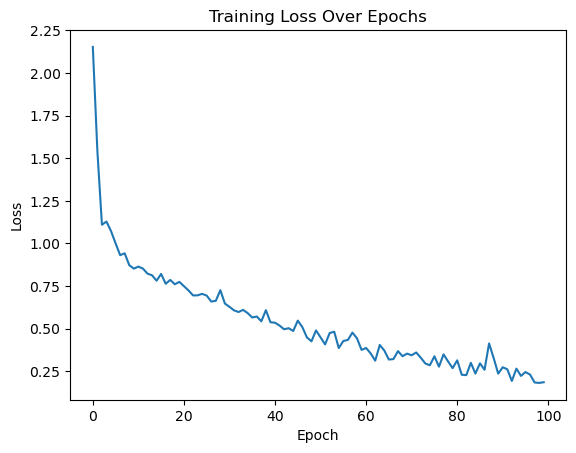

In [603]:
# train cnn
from tqdm import tqdm

loss_graph = []

for epoch in range(100):
    running_loss = 0.0
    loop = tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch+1}")
    
    for i, data in loop:
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Update tqdm progress bar description
        loop.set_postfix(loss=running_loss / (i + 1))

    loss_graph.append(running_loss / (i + 1))

print('Finished Training')

plt.plot(loss_graph)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [604]:
# save model
PATH = './cloud_model_2.pth'
torch.save(net2.state_dict(), PATH)

In [605]:
# look at distribution from test data for confirmation
from collections import Counter

all_labels = []
for _, labels in testloader:
    all_labels.extend(labels.tolist())

print(Counter(all_labels))
# should be 34, 28, 27 for test data set

Counter({1: 34, 0: 28, 2: 27})


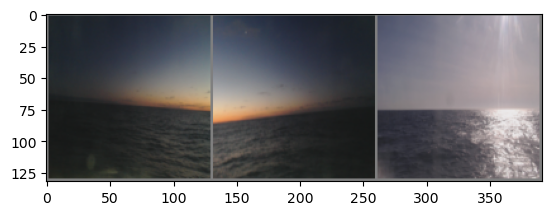

GroundTruth:  Clear Clear Clear


In [606]:
# preview and see if they're pulling correct labels

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(3)))

In [607]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net2(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the CNN on the 89 images: {100 * correct // total} %')

# averages ~62%.. which is better then randomly picking 1/3. 

Accuracy of the CNN on the 89 images: 61 %


In [608]:
# look at class accuracy -- cant help with deciding if we need better annotation/more data

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net2(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    

Accuracy for class: Clear is 39.3 %
Accuracy for class: Cloudy is 67.6 %
Accuracy for class: Overcast is 77.8 %
